1차: 바이너리 roi, 버드아이뷰, lane 필터

In [23]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)

    return warp_image

def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))

def lane_filter_apply(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HLS)   
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    filtered_img = cv2.bitwise_or(sobel_img, color_img)
    filtered_img = 255 * filtered_img #작동엔 이 코드가 필요 안하지만 개별 이전변환 적용된 영상들 띄우는덴 필요
    return filtered_img
	
def next_y(w, h=720, window_height=80):
  y_lo = h - (w + 1) * window_height
  y_hi = h - w * window_height 
  return y_lo, y_hi

def next_x(current ,margin=100):
  x_left = current - margin
  x_right = current + margin
  return x_left, x_right

def next_midx(current, all_pixels_x, pixel_indices, min_pix=50):
    if len(pixel_indices) > min_pix:
      current = int(np.mean(all_pixels_x[pixel_indices]))
    return current

def indices_within_boundary(all_pixels_x, all_pixels_y, y_lo, y_hi, x_left, x_right):
  cond1 = all_pixels_y >= y_lo
  cond2 = all_pixels_y < y_hi
  cond3 = all_pixels_x >= x_left
  cond4 = all_pixels_x < x_right
  return (cond1 & cond2 & cond3 & cond4 ).nonzero()[0]

def get_real_curvature(xs, ys, xm_per_pix=(3.7/700), ym_per_pix=(30/720)):
    return np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)

def radius_of_curvature(y, f):
    return ((1 + (2 * f[0] * y + f[1])**2)**(1.5)) / np.absolute(2 * f[0])

def pixel_locations(all_pixels_x, all_pixels_y, indices):
    return all_pixels_x[indices], all_pixels_y[indices]

def curves_fit(binary):  
  number_of_windows = 9
  margin = 100
  minimum_pixels = 50
  ym_per_pix = 30 / 720
  xm_per_pix = 3.7 / 700
  glo_left_pixels_indices, glo_right_pixels_indices = [], []
  left_pixels_x, left_pixels_y = None, None
  right_pixels_x, right_pixels_y = None, None
  left_fit_curve_pix, right_fit_curve_pix = None, None
  left_fit_curve_f, right_fit_curve_f = None, None
  left_radius, right_radius = None, None
  vehicle_position, vehicle_position_words = None, None
  result = {}

  # store details
  out_img = np.dstack((binary, binary, binary)) * 255
  h, w = binary.shape[0], binary.shape[1]
  mid = h/2
  window_height = int(h / number_of_windows)  
  all_pixels_x = np.array(binary.nonzero()[1])
  all_pixels_y = np.array(binary.nonzero()[0]) 

  # start : w 각 세로라인별 합을 구해서 그값이 가장 큰 세로줄을 시작으로 (좌/우 구분해서)
  hist = np.sum(binary[int(h / 2):, :], axis = 0)
  mid = int(hist.shape[0] / 2)
  mid_leftx = np.argmax(hist[:mid])
  mid_rightx = np.argmax(hist[mid:]) + mid
  
  left_pixels_indices, right_pixels_indices = [], []
  x, y = [None, None, None, None], [None, None]
  
  for w in range(number_of_windows):
    y[0], y[1] = next_y(w)
    x[0], x[1] = next_x(mid_leftx) 
    x[2], x[3] = next_x(mid_rightx)

    cv2.rectangle(out_img, (x[0], y[0]), (x[1], y[1]), (255, 0, 0), thickness=4)  
    cv2.rectangle(out_img, (x[2], y[0]), (x[3], y[1]), (0, 255, 0), thickness=4)
    
    curr_left_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y, y[0], y[1], x[0], x[1])
    curr_right_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y,y[0], y[1], x[2], x[3])
        
    left_pixels_indices.append(curr_left_pixels_indices)
    right_pixels_indices.append(curr_right_pixels_indices)
    
    mid_leftx = next_midx(mid_leftx, all_pixels_x, curr_left_pixels_indices)
    mid_rightx = next_midx(mid_rightx, all_pixels_x, curr_right_pixels_indices)
    
  glo_left_pixels_indices = np.concatenate(left_pixels_indices)
  glo_right_pixels_indices = np.concatenate(right_pixels_indices)
  
  left_pixels_x, left_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_left_pixels_indices)
  right_pixels_x, right_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_right_pixels_indices)

  left_fit_curve_f = get_real_curvature(left_pixels_x, left_pixels_y)
  right_fit_curve_f = get_real_curvature(right_pixels_x, right_pixels_y)
  
  left_radius = radius_of_curvature(h * ym_per_pix, left_fit_curve_f)
  right_radius = radius_of_curvature(h *  ym_per_pix, right_fit_curve_f)

  #plot
  out_img[left_pixels_y, left_pixels_x] = [255, 0, 255]
  out_img[right_pixels_y, right_pixels_x] = [0, 255, 255]

  left_fit_curve_pix = np.polyfit(left_pixels_y, left_pixels_x, 2)
  right_fit_curve_pix = np.polyfit(right_pixels_y, right_pixels_x, 2)

  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  ys = np.linspace(0, h - 1, h)
  
  left_xs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
  right_xs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
  
  xls, xrs, ys = left_xs.astype(np.uint32), right_xs.astype(np.uint32), ys.astype(np.uint32)
  
  t=4
  for xl, xr, y in zip(xls, xrs, ys):
      cv2.line(out_img, (xl - t, y), (xl + t, y), (255, 255, 0), int(t / 2))
      cv2.line(out_img, (xr - t, y), (xr + t, y), (0, 0, 255), int(t / 2))

  #update_vehicle_position
  y = h
  mid = w / 2
  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  xl = kl[0] * (y**2) + kl[1]* y + kl[2]
  xr = kr[0] * (y**2) + kr[1]* y + kr[2]
  pix_pos = xl + (xr - xl) / 2
  vehicle_position = (pix_pos - mid) * xm_per_pix 

  if vehicle_position < 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m left of center"
  elif vehicle_position > 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m right of center"
  else:
    vehicle_position_words = "at the center"


  result = {
    'image': out_img,
    'left_radius': left_radius,
    'right_radius': right_radius,
    'real_left_best_fit_curve': left_fit_curve_f,
    'real_right_best_fit_curve': right_fit_curve_f, 
    'pixel_left_best_fit_curve': left_fit_curve_pix,
    'pixel_right_best_fit_curve': right_fit_curve_pix, 
    'vehicle_position': vehicle_position, 
    'vehicle_position_words': vehicle_position_words
  }
  return result
  
def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def process_video(input_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print('동영상을 열 수 없습니다.')
        exit(1)

    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    while True:
        ret, frame = cap.read()
        if not ret:
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            img_binary = lane_filter_apply(frame)
            cv2.imshow('1. Lane Filtered Image', img_binary)  # 추가: lane filtering 결과

            birdview_image = birdeye_sky_view(img_binary)
            cv2.imshow('2. Bird\'s-eye View', birdview_image)  # 추가: bird's-eye view 결과

            roi_image = roi(birdview_image, mn=125, mx=1200) # roi 함수 적용, 매개변수 추가
            cv2.imshow('3. ROI Applied', roi_image)  # 추가: ROI 적용 결과


            result = curves_fit(birdview_image)
            processed_frame = project_image(frame, birdview_image, result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve'])
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

            cv2.imshow('5. Curves Fit Result', result['image'])

            height, width = frame.shape[:2]
            frame_now = cap.get(cv2.CAP_PROP_POS_FRAMES)
            processed_frame = cv2.putText(processed_frame, f'{int(frame_now):04d} / {int(frame_num):04d}', (10, 30),
                                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

            cv2.imshow('4. Final Result', processed_frame) # 최종 결과 영상을 명확하게 표시

        except Exception as e:
            print(f"Error processing frame: {e}")
            cv2.imshow('video', frame)  # 에러 발생 시 원본 프레임 표시

        if cv2.waitKey(33) == 27:  # Esc 키
            break

    cap.release()
    cv2.destroyAllWindows()


def project_lane_test_for_video(img): # 함수 이름 변경
    """
    project_lane_test 함수를 비디오 처리에 맞게 수정했습니다. 
    matplotlib.pyplot 사용을 제거하고 결과 이미지만 반환합니다.
    """
    ground_img = img.copy()
    img_binary = lane_filter_apply(img)
    wb = np.logical_and(birdeye_sky_view(img_binary), roi(img_binary)).astype(np.uint8)
    result = curves_fit(wb)

    ground_img = project_image(ground_img, img_binary, 
                             result['pixel_left_best_fit_curve'], 
                             result['pixel_right_best_fit_curve'])
    return ground_img
	
	

In [24]:
input_video = r'C:\Users\HKIT\vscode\numpy\v24_11_29b\videos\project_video_output.mp4'  # 입력 비디오 파일 경로
process_video(input_video)

2차: 칼라브레이크 다운, 소벨브레이크 다운, 커브 핏

In [27]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)

    return warp_image

def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))

def lane_filter_apply(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HLS)   
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    filtered_img = cv2.bitwise_or(sobel_img, color_img)
    return filtered_img
	
def next_y(w, h=720, window_height=80):
  y_lo = h - (w + 1) * window_height
  y_hi = h - w * window_height 
  return y_lo, y_hi

def next_x(current ,margin=100):
  x_left = current - margin
  x_right = current + margin
  return x_left, x_right

def next_midx(current, all_pixels_x, pixel_indices, min_pix=50):
    if len(pixel_indices) > min_pix:
      current = int(np.mean(all_pixels_x[pixel_indices]))
    return current

def indices_within_boundary(all_pixels_x, all_pixels_y, y_lo, y_hi, x_left, x_right):
  cond1 = all_pixels_y >= y_lo
  cond2 = all_pixels_y < y_hi
  cond3 = all_pixels_x >= x_left
  cond4 = all_pixels_x < x_right
  return (cond1 & cond2 & cond3 & cond4 ).nonzero()[0]

def get_real_curvature(xs, ys, xm_per_pix=(3.7/700), ym_per_pix=(30/720)):
    return np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)

def radius_of_curvature(y, f):
    return ((1 + (2 * f[0] * y + f[1])**2)**(1.5)) / np.absolute(2 * f[0])

def pixel_locations(all_pixels_x, all_pixels_y, indices):
    return all_pixels_x[indices], all_pixels_y[indices]

def curves_fit(binary):  
  number_of_windows = 9
  margin = 100
  minimum_pixels = 50
  ym_per_pix = 30 / 720
  xm_per_pix = 3.7 / 700
  glo_left_pixels_indices, glo_right_pixels_indices = [], []
  left_pixels_x, left_pixels_y = None, None
  right_pixels_x, right_pixels_y = None, None
  left_fit_curve_pix, right_fit_curve_pix = None, None
  left_fit_curve_f, right_fit_curve_f = None, None
  left_radius, right_radius = None, None
  vehicle_position, vehicle_position_words = None, None
  result = {}

  # store details
  out_img = np.dstack((binary, binary, binary)) * 255
  h, w = binary.shape[0], binary.shape[1]
  mid = h/2
  window_height = int(h / number_of_windows)  
  all_pixels_x = np.array(binary.nonzero()[1])
  all_pixels_y = np.array(binary.nonzero()[0]) 

  # start : w 각 세로라인별 합을 구해서 그값이 가장 큰 세로줄을 시작으로 (좌/우 구분해서)
  hist = np.sum(binary[int(h / 2):, :], axis = 0)
  mid = int(hist.shape[0] / 2)
  mid_leftx = np.argmax(hist[:mid])
  mid_rightx = np.argmax(hist[mid:]) + mid
  
  left_pixels_indices, right_pixels_indices = [], []
  x, y = [None, None, None, None], [None, None]
  
  for w in range(number_of_windows):
    y[0], y[1] = next_y(w)
    x[0], x[1] = next_x(mid_leftx) 
    x[2], x[3] = next_x(mid_rightx)

    cv2.rectangle(out_img, (x[0], y[0]), (x[1], y[1]), (255, 0, 0), thickness=4)  
    cv2.rectangle(out_img, (x[2], y[0]), (x[3], y[1]), (0, 255, 0), thickness=4)
    
    curr_left_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y, y[0], y[1], x[0], x[1])
    curr_right_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y,y[0], y[1], x[2], x[3])
        
    left_pixels_indices.append(curr_left_pixels_indices)
    right_pixels_indices.append(curr_right_pixels_indices)
    
    mid_leftx = next_midx(mid_leftx, all_pixels_x, curr_left_pixels_indices)
    mid_rightx = next_midx(mid_rightx, all_pixels_x, curr_right_pixels_indices)
    
  glo_left_pixels_indices = np.concatenate(left_pixels_indices)
  glo_right_pixels_indices = np.concatenate(right_pixels_indices)
  
  left_pixels_x, left_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_left_pixels_indices)
  right_pixels_x, right_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_right_pixels_indices)

  left_fit_curve_f = get_real_curvature(left_pixels_x, left_pixels_y)
  right_fit_curve_f = get_real_curvature(right_pixels_x, right_pixels_y)
  
  left_radius = radius_of_curvature(h * ym_per_pix, left_fit_curve_f)
  right_radius = radius_of_curvature(h *  ym_per_pix, right_fit_curve_f)

  #plot
  out_img[left_pixels_y, left_pixels_x] = [255, 0, 255]
  out_img[right_pixels_y, right_pixels_x] = [0, 255, 255]

  left_fit_curve_pix = np.polyfit(left_pixels_y, left_pixels_x, 2)
  right_fit_curve_pix = np.polyfit(right_pixels_y, right_pixels_x, 2)

  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  ys = np.linspace(0, h - 1, h)
  
  left_xs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
  right_xs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
  
  xls, xrs, ys = left_xs.astype(np.uint32), right_xs.astype(np.uint32), ys.astype(np.uint32)
  
  t=4
  for xl, xr, y in zip(xls, xrs, ys):
      cv2.line(out_img, (xl - t, y), (xl + t, y), (255, 255, 0), int(t / 2))
      cv2.line(out_img, (xr - t, y), (xr + t, y), (0, 0, 255), int(t / 2))

  #update_vehicle_position
  y = h
  mid = w / 2
  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  xl = kl[0] * (y**2) + kl[1]* y + kl[2]
  xr = kr[0] * (y**2) + kr[1]* y + kr[2]
  pix_pos = xl + (xr - xl) / 2
  vehicle_position = (pix_pos - mid) * xm_per_pix 

  if vehicle_position < 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m left of center"
  elif vehicle_position > 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m right of center"
  else:
    vehicle_position_words = "at the center"


  result = {
    'image': out_img,
    'left_radius': left_radius,
    'right_radius': right_radius,
    'real_left_best_fit_curve': left_fit_curve_f,
    'real_right_best_fit_curve': right_fit_curve_f, 
    'pixel_left_best_fit_curve': left_fit_curve_pix,
    'pixel_right_best_fit_curve': right_fit_curve_pix, 
    'vehicle_position': vehicle_position, 
    'vehicle_position_words': vehicle_position_words
  }
  return result
  
def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def process_video(input_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print('동영상을 열 수 없습니다.')
        exit(1)

    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 동영상 끝에 도달하면 루프 종료

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            img_binary = lane_filter_apply(frame)
            birdview_image = birdeye_sky_view(img_binary)
            roi_image = roi(birdview_image, mn=125, mx=1200) 

            # Sobel 분해 결과 이미지 생성 및 표시//디버깅용
            sobel_breakdown_img = sobel_breakdown(frame)
            sobel_breakdown_img = cv2.cvtColor(sobel_breakdown_img, cv2.COLOR_RGB2BGR) #BGR로 변환
            cv2.imshow('Sobel Breakdown', sobel_breakdown_img)

            # Color 분해 결과 이미지 생성 및 표시//디버깅용
            color_breakdown_img = color_breakdown(frame)
            color_breakdown_img = cv2.cvtColor(color_breakdown_img, cv2.COLOR_RGB2BGR) #BGR로 변환
            cv2.imshow('Color Breakdown', color_breakdown_img)

            result = curves_fit(birdview_image)
            processed_frame = project_image(frame, birdview_image, result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve'])
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

            # 커브 핏 확인//디버깅용
            cv2.imshow('Curves Fit Result', result['image'])

            height, width = frame.shape[:2]
            frame_now = cap.get(cv2.CAP_PROP_POS_FRAMES)
            processed_frame = cv2.putText(processed_frame, f'{int(frame_now):04d} / {int(frame_num):04d}', (10, 30),
                                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

            cv2.imshow('Final Result', processed_frame) 

        except Exception as e:
            print(f"Error processing frame {cap.get(cv2.CAP_PROP_POS_FRAMES)}: {e}")
            # 에러 발생 시에도 최소한의 정보를 출력하고 다음 프레임으로 진행

        if cv2.waitKey(33) == 27:  # Esc 키
            break

    cap.release()
    cv2.destroyAllWindows()


def project_lane_test_for_video(img): # 함수 이름 변경
    """
    project_lane_test 함수를 비디오 처리에 맞게 수정했습니다. 
    matplotlib.pyplot 사용을 제거하고 결과 이미지만 반환합니다.
    """
    ground_img = img.copy()
    img_binary = lane_filter_apply(img)
    wb = np.logical_and(birdeye_sky_view(img_binary), roi(img_binary)).astype(np.uint8)
    result = curves_fit(wb)

    ground_img = project_image(ground_img, img_binary, 
                             result['pixel_left_best_fit_curve'], 
                             result['pixel_right_best_fit_curve'])
    return ground_img
	
	

In [28]:
input_video = r'C:\Users\HKIT\vscode\numpy\v24_11_29b\videos\project_video_output.mp4'  # 입력 비디오 파일 경로
process_video(input_video)

2차: 이거 사용 추천

In [46]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)

    return warp_image

def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))

def lane_filter_apply(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HLS)   
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    filtered_img = cv2.bitwise_or(sobel_img, color_img)
    return filtered_img
	
def next_y(w, h=720, window_height=80):
  y_lo = h - (w + 1) * window_height
  y_hi = h - w * window_height 
  return y_lo, y_hi

def next_x(current ,margin=100):
  x_left = current - margin
  x_right = current + margin
  return x_left, x_right

def next_midx(current, all_pixels_x, pixel_indices, min_pix=50):
    if len(pixel_indices) > min_pix:
      current = int(np.mean(all_pixels_x[pixel_indices]))
    return current

def indices_within_boundary(all_pixels_x, all_pixels_y, y_lo, y_hi, x_left, x_right):
  cond1 = all_pixels_y >= y_lo
  cond2 = all_pixels_y < y_hi
  cond3 = all_pixels_x >= x_left
  cond4 = all_pixels_x < x_right
  return (cond1 & cond2 & cond3 & cond4 ).nonzero()[0]

def get_real_curvature(xs, ys, xm_per_pix=(3.7/700), ym_per_pix=(30/720)):
    return np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)

def radius_of_curvature(y, f):
    return ((1 + (2 * f[0] * y + f[1])**2)**(1.5)) / np.absolute(2 * f[0])

def pixel_locations(all_pixels_x, all_pixels_y, indices):
    return all_pixels_x[indices], all_pixels_y[indices]

def curves_fit(binary):  
  number_of_windows = 9
  margin = 100
  minimum_pixels = 50
  ym_per_pix = 30 / 720
  xm_per_pix = 3.7 / 700
  glo_left_pixels_indices, glo_right_pixels_indices = [], []
  left_pixels_x, left_pixels_y = None, None
  right_pixels_x, right_pixels_y = None, None
  left_fit_curve_pix, right_fit_curve_pix = None, None
  left_fit_curve_f, right_fit_curve_f = None, None
  left_radius, right_radius = None, None
  vehicle_position, vehicle_position_words = None, None
  result = {}

  # store details
  out_img = np.dstack((binary, binary, binary)) * 255
  h, w = binary.shape[0], binary.shape[1]
  mid = h/2
  window_height = int(h / number_of_windows)  
  all_pixels_x = np.array(binary.nonzero()[1])
  all_pixels_y = np.array(binary.nonzero()[0]) 

  # start : w 각 세로라인별 합을 구해서 그값이 가장 큰 세로줄을 시작으로 (좌/우 구분해서)
  hist = np.sum(binary[int(h / 2):, :], axis = 0)
  mid = int(hist.shape[0] / 2)
  mid_leftx = np.argmax(hist[:mid])
  mid_rightx = np.argmax(hist[mid:]) + mid
  
  left_pixels_indices, right_pixels_indices = [], []
  x, y = [None, None, None, None], [None, None]
  
  for w in range(number_of_windows):
    y[0], y[1] = next_y(w)
    x[0], x[1] = next_x(mid_leftx) 
    x[2], x[3] = next_x(mid_rightx)

    cv2.rectangle(out_img, (x[0], y[0]), (x[1], y[1]), (255, 0, 0), thickness=4)  
    cv2.rectangle(out_img, (x[2], y[0]), (x[3], y[1]), (0, 255, 0), thickness=4)
    
    curr_left_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y, y[0], y[1], x[0], x[1])
    curr_right_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y,y[0], y[1], x[2], x[3])
        
    left_pixels_indices.append(curr_left_pixels_indices)
    right_pixels_indices.append(curr_right_pixels_indices)
    
    mid_leftx = next_midx(mid_leftx, all_pixels_x, curr_left_pixels_indices)
    mid_rightx = next_midx(mid_rightx, all_pixels_x, curr_right_pixels_indices)
    
  glo_left_pixels_indices = np.concatenate(left_pixels_indices)
  glo_right_pixels_indices = np.concatenate(right_pixels_indices)
  
  left_pixels_x, left_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_left_pixels_indices)
  right_pixels_x, right_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_right_pixels_indices)

  left_fit_curve_f = get_real_curvature(left_pixels_x, left_pixels_y)
  right_fit_curve_f = get_real_curvature(right_pixels_x, right_pixels_y)
  
  left_radius = radius_of_curvature(h * ym_per_pix, left_fit_curve_f)
  right_radius = radius_of_curvature(h *  ym_per_pix, right_fit_curve_f)

  #plot
  out_img[left_pixels_y, left_pixels_x] = [255, 0, 255]
  out_img[right_pixels_y, right_pixels_x] = [0, 255, 255]

  left_fit_curve_pix = np.polyfit(left_pixels_y, left_pixels_x, 2)
  right_fit_curve_pix = np.polyfit(right_pixels_y, right_pixels_x, 2)

  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  ys = np.linspace(0, h - 1, h)
  
  left_xs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
  right_xs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
  
  xls, xrs, ys = left_xs.astype(np.uint32), right_xs.astype(np.uint32), ys.astype(np.uint32)
  
  t=4
  for xl, xr, y in zip(xls, xrs, ys):
      cv2.line(out_img, (xl - t, y), (xl + t, y), (255, 255, 0), int(t / 2))
      cv2.line(out_img, (xr - t, y), (xr + t, y), (0, 0, 255), int(t / 2))

  #update_vehicle_position
  y = h
  mid = w / 2
  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  xl = kl[0] * (y**2) + kl[1]* y + kl[2]
  xr = kr[0] * (y**2) + kr[1]* y + kr[2]
  pix_pos = xl + (xr - xl) / 2
  vehicle_position = (pix_pos - mid) * xm_per_pix 

  if vehicle_position < 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m left of center"
  elif vehicle_position > 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m right of center"
  else:
    vehicle_position_words = "at the center"


  result = {
    'image': out_img,
    'left_radius': left_radius,
    'right_radius': right_radius,
    'real_left_best_fit_curve': left_fit_curve_f,
    'real_right_best_fit_curve': right_fit_curve_f, 
    'pixel_left_best_fit_curve': left_fit_curve_pix,
    'pixel_right_best_fit_curve': right_fit_curve_pix, 
    'vehicle_position': vehicle_position, 
    'vehicle_position_words': vehicle_position_words
  }
  return result
  
def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def process_video(input_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print('동영상을 열 수 없습니다.')
        exit(1)

    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 동영상 끝에 도달하면 루프 종료

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            img_binary = lane_filter_apply(frame)
            birdview_image = birdeye_sky_view(img_binary)
            roi_image = roi(birdview_image, mn=125, mx=1200) 

            birdeye_color = birdeye_sky_view(frame)
            cv2.imshow('bird', birdeye_color)

            # Sobel 분해 결과 이미지 생성 및 표시//디버깅용
            sobel_breakdown_img = sobel_breakdown(frame)
            sobel_breakdown_img = cv2.cvtColor(sobel_breakdown_img, cv2.COLOR_RGB2BGR) #BGR로 변환
            cv2.imshow('Sobel Breakdown', sobel_breakdown_img)

            # Color 분해 결과 이미지 생성 및 표시//디버깅용
            color_breakdown_img = color_breakdown(frame)
            color_breakdown_img = cv2.cvtColor(color_breakdown_img, cv2.COLOR_RGB2BGR) #BGR로 변환
            cv2.imshow('Color Breakdown', color_breakdown_img)

            result = curves_fit(birdview_image)
            processed_frame = project_image(frame, birdview_image, result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve'])
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

            # 커브 핏 확인//디버깅용
            cv2.imshow('Curves Fit Result', result['image'])

            height, width = frame.shape[:2]
            frame_now = cap.get(cv2.CAP_PROP_POS_FRAMES)
            processed_frame = cv2.putText(processed_frame, f'{int(frame_now):04d} / {int(frame_num):04d}', (10, 30),
                                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

            cv2.imshow('Final Result', processed_frame) 

        except Exception as e:
            print(f"Error processing frame {cap.get(cv2.CAP_PROP_POS_FRAMES)}: {e}")
            # 에러 발생 시에도 최소한의 정보를 출력하고 다음 프레임으로 진행

        if cv2.waitKey(33) == 27:  # Esc 키
            break

    cap.release()
    cv2.destroyAllWindows()
	

In [47]:
input_video = r'C:\Users\HKIT\vscode\numpy\v24_11_29b\videos\project_video.mp4'  # 입력 비디오 파일 경로
process_video(input_video)

3차. 합본판. 실제로 원하는 건 이걸로 봄.

In [77]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)

    return warp_image

def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))

def lane_filter_apply(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HLS)   
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    filtered_img = cv2.bitwise_or(sobel_img, color_img)
    return filtered_img
	
def next_y(w, h=720, window_height=80):
  y_lo = h - (w + 1) * window_height
  y_hi = h - w * window_height 
  return y_lo, y_hi

def next_x(current ,margin=100):
  x_left = current - margin
  x_right = current + margin
  return x_left, x_right

def next_midx(current, all_pixels_x, pixel_indices, min_pix=50):
    if len(pixel_indices) > min_pix:
      current = int(np.mean(all_pixels_x[pixel_indices]))
    return current

def indices_within_boundary(all_pixels_x, all_pixels_y, y_lo, y_hi, x_left, x_right):
  cond1 = all_pixels_y >= y_lo
  cond2 = all_pixels_y < y_hi
  cond3 = all_pixels_x >= x_left
  cond4 = all_pixels_x < x_right
  return (cond1 & cond2 & cond3 & cond4 ).nonzero()[0]

def get_real_curvature(xs, ys, xm_per_pix=(3.7/700), ym_per_pix=(30/720)):
    return np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)

def radius_of_curvature(y, f):
    return ((1 + (2 * f[0] * y + f[1])**2)**(1.5)) / np.absolute(2 * f[0])

def pixel_locations(all_pixels_x, all_pixels_y, indices):
    return all_pixels_x[indices], all_pixels_y[indices]

def curves_fit(binary):  
  number_of_windows = 9
  margin = 100
  minimum_pixels = 50
  ym_per_pix = 30 / 720
  xm_per_pix = 3.7 / 700
  glo_left_pixels_indices, glo_right_pixels_indices = [], []
  left_pixels_x, left_pixels_y = None, None
  right_pixels_x, right_pixels_y = None, None
  left_fit_curve_pix, right_fit_curve_pix = None, None
  left_fit_curve_f, right_fit_curve_f = None, None
  left_radius, right_radius = None, None
  vehicle_position, vehicle_position_words = None, None
  result = {}

  # store details
  out_img = np.dstack((binary, binary, binary)) * 255
  h, w = binary.shape[0], binary.shape[1]
  mid = h/2
  window_height = int(h / number_of_windows)  
  all_pixels_x = np.array(binary.nonzero()[1])
  all_pixels_y = np.array(binary.nonzero()[0]) 

  # start : w 각 세로라인별 합을 구해서 그값이 가장 큰 세로줄을 시작으로 (좌/우 구분해서)
  hist = np.sum(binary[int(h / 2):, :], axis = 0)
  mid = int(hist.shape[0] / 2)
  mid_leftx = np.argmax(hist[:mid])
  mid_rightx = np.argmax(hist[mid:]) + mid
  
  left_pixels_indices, right_pixels_indices = [], []
  x, y = [None, None, None, None], [None, None]
  
  for w in range(number_of_windows):
    y[0], y[1] = next_y(w)
    x[0], x[1] = next_x(mid_leftx) 
    x[2], x[3] = next_x(mid_rightx)

    cv2.rectangle(out_img, (x[0], y[0]), (x[1], y[1]), (255, 0, 0), thickness=4)  
    cv2.rectangle(out_img, (x[2], y[0]), (x[3], y[1]), (0, 255, 0), thickness=4)
    
    curr_left_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y, y[0], y[1], x[0], x[1])
    curr_right_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y,y[0], y[1], x[2], x[3])
        
    left_pixels_indices.append(curr_left_pixels_indices)
    right_pixels_indices.append(curr_right_pixels_indices)
    
    mid_leftx = next_midx(mid_leftx, all_pixels_x, curr_left_pixels_indices)
    mid_rightx = next_midx(mid_rightx, all_pixels_x, curr_right_pixels_indices)
    
  glo_left_pixels_indices = np.concatenate(left_pixels_indices)
  glo_right_pixels_indices = np.concatenate(right_pixels_indices)
  
  left_pixels_x, left_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_left_pixels_indices)
  right_pixels_x, right_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_right_pixels_indices)

  left_fit_curve_f = get_real_curvature(left_pixels_x, left_pixels_y)
  right_fit_curve_f = get_real_curvature(right_pixels_x, right_pixels_y)
  
  left_radius = radius_of_curvature(h * ym_per_pix, left_fit_curve_f)
  right_radius = radius_of_curvature(h *  ym_per_pix, right_fit_curve_f)

  #plot
  out_img[left_pixels_y, left_pixels_x] = [255, 0, 255]
  out_img[right_pixels_y, right_pixels_x] = [0, 255, 255]

  left_fit_curve_pix = np.polyfit(left_pixels_y, left_pixels_x, 2)
  right_fit_curve_pix = np.polyfit(right_pixels_y, right_pixels_x, 2)

  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  ys = np.linspace(0, h - 1, h)
  
  left_xs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
  right_xs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
  
  xls, xrs, ys = left_xs.astype(np.uint32), right_xs.astype(np.uint32), ys.astype(np.uint32)
  
  t=4
  for xl, xr, y in zip(xls, xrs, ys):
      cv2.line(out_img, (xl - t, y), (xl + t, y), (255, 255, 0), int(t / 2))
      cv2.line(out_img, (xr - t, y), (xr + t, y), (0, 0, 255), int(t / 2))

  #update_vehicle_position
  y = h
  mid = w / 2
  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  xl = kl[0] * (y**2) + kl[1]* y + kl[2]
  xr = kr[0] * (y**2) + kr[1]* y + kr[2]
  pix_pos = xl + (xr - xl) / 2
  vehicle_position = (pix_pos - mid) * xm_per_pix 

  if vehicle_position < 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m left of center"
  elif vehicle_position > 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m right of center"
  else:
    vehicle_position_words = "at the center"


  result = {
    'image': out_img,
    'left_radius': left_radius,
    'right_radius': right_radius,
    'real_left_best_fit_curve': left_fit_curve_f,
    'real_right_best_fit_curve': right_fit_curve_f, 
    'pixel_left_best_fit_curve': left_fit_curve_pix,
    'pixel_right_best_fit_curve': right_fit_curve_pix, 
    'vehicle_position': vehicle_position, 
    'vehicle_position_words': vehicle_position_words
  }
  return result
  
def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def process_video(input_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print('동영상을 열 수 없습니다.')
        exit(1)

    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        try:
            img_binary = lane_filter_apply(frame)
            birdview_image = birdeye_sky_view(img_binary)
            roi_image = roi(birdview_image, mn=125, mx=1200) 

            birdeye_color = birdeye_sky_view(frame)
            sobel_breakdown_img = sobel_breakdown(frame)
            sobel_breakdown_img = cv2.cvtColor(sobel_breakdown_img, cv2.COLOR_RGB2BGR)
            color_breakdown_img = color_breakdown(frame)
            color_breakdown_img = cv2.cvtColor(color_breakdown_img, cv2.COLOR_RGB2BGR)

            result = curves_fit(birdview_image)
            processed_frame = project_image(frame, birdview_image, result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve'])
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)

            # 최종 영상의 크기 가져오기
            final_height, final_width = processed_frame.shape[:2]

            # 상단 영상 크기 조정 (최종 영상의 1/4 크기)
            resized_height = final_height // 4
            resized_width = final_width // 4

            birdview_image = cv2.resize(birdeye_color, (resized_width, resized_height), interpolation=cv2.INTER_AREA)
            sobel_breakdown_img = cv2.resize(sobel_breakdown_img, (resized_width, resized_height), interpolation=cv2.INTER_AREA)
            color_breakdown_img = cv2.resize(color_breakdown_img, (resized_width, resized_height), interpolation=cv2.INTER_AREA)

            # 수정된 부분: 마지막 이미지를 curves_fit 결과로 변경
            curves_fit_image = cv2.resize(result['image'], (resized_width, resized_height), interpolation=cv2.INTER_AREA)


            # 상단 이미지들을 hconcat으로 합침
            top_row = np.concatenate((birdview_image, sobel_breakdown_img, color_breakdown_img, curves_fit_image), axis=1)

            # 프레임 번호 추가
            frame_now = cap.get(cv2.CAP_PROP_POS_FRAMES)
            processed_frame = cv2.putText(processed_frame, f'{int(frame_now):04d} / {int(frame_num):04d}', (10, 30),
                                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

            # 상단 이미지와 하단 이미지를 vconcat으로 합침
            final_result = np.concatenate((top_row, processed_frame), axis=0)

            cv2.imshow('Final Result', final_result)

        except Exception as e:
            print(f"Error processing frame {cap.get(cv2.CAP_PROP_POS_FRAMES)}: {e}")

        if cv2.waitKey(33) == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

In [78]:
input_video = r'C:\Users\HKIT\vscode\numpy\v24_11_29b\videos\project_video.mp4'  # 입력 비디오 파일 경로
process_video(input_video)

4차. 이미지용 수정본

In [3]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)

    return warp_image

def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))

def lane_filter_apply(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HLS)   
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    filtered_img = cv2.bitwise_or(sobel_img, color_img)
    return filtered_img
	
def next_y(w, h=720, window_height=80):
  y_lo = h - (w + 1) * window_height
  y_hi = h - w * window_height 
  return y_lo, y_hi

def next_x(current ,margin=100):
  x_left = current - margin
  x_right = current + margin
  return x_left, x_right

def next_midx(current, all_pixels_x, pixel_indices, min_pix=50):
    if len(pixel_indices) > min_pix:
      current = int(np.mean(all_pixels_x[pixel_indices]))
    return current

def indices_within_boundary(all_pixels_x, all_pixels_y, y_lo, y_hi, x_left, x_right):
  cond1 = all_pixels_y >= y_lo
  cond2 = all_pixels_y < y_hi
  cond3 = all_pixels_x >= x_left
  cond4 = all_pixels_x < x_right
  return (cond1 & cond2 & cond3 & cond4 ).nonzero()[0]

def get_real_curvature(xs, ys, xm_per_pix=(3.7/700), ym_per_pix=(30/720)):
    return np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)

def radius_of_curvature(y, f):
    return ((1 + (2 * f[0] * y + f[1])**2)**(1.5)) / np.absolute(2 * f[0])

def pixel_locations(all_pixels_x, all_pixels_y, indices):
    return all_pixels_x[indices], all_pixels_y[indices]

def curves_fit(binary):  
  number_of_windows = 9
  margin = 100
  minimum_pixels = 50
  ym_per_pix = 30 / 720
  xm_per_pix = 3.7 / 700
  glo_left_pixels_indices, glo_right_pixels_indices = [], []
  left_pixels_x, left_pixels_y = None, None
  right_pixels_x, right_pixels_y = None, None
  left_fit_curve_pix, right_fit_curve_pix = None, None
  left_fit_curve_f, right_fit_curve_f = None, None
  left_radius, right_radius = None, None
  vehicle_position, vehicle_position_words = None, None
  result = {}

  # store details
  out_img = np.dstack((binary, binary, binary)) * 255
  h, w = binary.shape[0], binary.shape[1]
  mid = h/2
  window_height = int(h / number_of_windows)  
  all_pixels_x = np.array(binary.nonzero()[1])
  all_pixels_y = np.array(binary.nonzero()[0]) 

  # start : w 각 세로라인별 합을 구해서 그값이 가장 큰 세로줄을 시작으로 (좌/우 구분해서)
  hist = np.sum(binary[int(h / 2):, :], axis = 0)
  mid = int(hist.shape[0] / 2)
  mid_leftx = np.argmax(hist[:mid])
  mid_rightx = np.argmax(hist[mid:]) + mid
  
  left_pixels_indices, right_pixels_indices = [], []
  x, y = [None, None, None, None], [None, None]
  
  for w in range(number_of_windows):
    y[0], y[1] = next_y(w)
    x[0], x[1] = next_x(mid_leftx) 
    x[2], x[3] = next_x(mid_rightx)

    cv2.rectangle(out_img, (x[0], y[0]), (x[1], y[1]), (255, 0, 0), thickness=4)  
    cv2.rectangle(out_img, (x[2], y[0]), (x[3], y[1]), (0, 255, 0), thickness=4)
    
    curr_left_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y, y[0], y[1], x[0], x[1])
    curr_right_pixels_indices = indices_within_boundary(all_pixels_x, all_pixels_y,y[0], y[1], x[2], x[3])
        
    left_pixels_indices.append(curr_left_pixels_indices)
    right_pixels_indices.append(curr_right_pixels_indices)
    
    mid_leftx = next_midx(mid_leftx, all_pixels_x, curr_left_pixels_indices)
    mid_rightx = next_midx(mid_rightx, all_pixels_x, curr_right_pixels_indices)
    
  glo_left_pixels_indices = np.concatenate(left_pixels_indices)
  glo_right_pixels_indices = np.concatenate(right_pixels_indices)
  
  left_pixels_x, left_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_left_pixels_indices)
  right_pixels_x, right_pixels_y = pixel_locations(all_pixels_x, all_pixels_y, glo_right_pixels_indices)

  left_fit_curve_f = get_real_curvature(left_pixels_x, left_pixels_y)
  right_fit_curve_f = get_real_curvature(right_pixels_x, right_pixels_y)
  
  left_radius = radius_of_curvature(h * ym_per_pix, left_fit_curve_f)
  right_radius = radius_of_curvature(h *  ym_per_pix, right_fit_curve_f)

  #plot
  out_img[left_pixels_y, left_pixels_x] = [255, 0, 255]
  out_img[right_pixels_y, right_pixels_x] = [0, 255, 255]

  left_fit_curve_pix = np.polyfit(left_pixels_y, left_pixels_x, 2)
  right_fit_curve_pix = np.polyfit(right_pixels_y, right_pixels_x, 2)

  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  ys = np.linspace(0, h - 1, h)
  
  left_xs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
  right_xs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
  
  xls, xrs, ys = left_xs.astype(np.uint32), right_xs.astype(np.uint32), ys.astype(np.uint32)
  
  t=4
  for xl, xr, y in zip(xls, xrs, ys):
      cv2.line(out_img, (xl - t, y), (xl + t, y), (255, 255, 0), int(t / 2))
      cv2.line(out_img, (xr - t, y), (xr + t, y), (0, 0, 255), int(t / 2))

  #update_vehicle_position
  y = h
  mid = w / 2
  kl, kr = left_fit_curve_pix, right_fit_curve_pix
  xl = kl[0] * (y**2) + kl[1]* y + kl[2]
  xr = kr[0] * (y**2) + kr[1]* y + kr[2]
  pix_pos = xl + (xr - xl) / 2
  vehicle_position = (pix_pos - mid) * xm_per_pix 

  if vehicle_position < 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m left of center"
  elif vehicle_position > 0:
    vehicle_position_words = str(np.absolute(np.round(vehicle_position, 2))) + " m right of center"
  else:
    vehicle_position_words = "at the center"


  result = {
    'image': out_img,
    'left_radius': left_radius,
    'right_radius': right_radius,
    'real_left_best_fit_curve': left_fit_curve_f,
    'real_right_best_fit_curve': right_fit_curve_f, 
    'pixel_left_best_fit_curve': left_fit_curve_pix,
    'pixel_right_best_fit_curve': right_fit_curve_pix, 
    'vehicle_position': vehicle_position, 
    'vehicle_position_words': vehicle_position_words
  }
  return result
  
def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def project_image(ground_image, sky_lane, left_fit, right_fit, color = (0, 255, 0)):
    z = np.zeros_like(sky_lane)
    sky_lane = np.dstack((z, z, z))

    kl, kr = left_fit, right_fit
    h = sky_lane.shape[0]
    ys = np.linspace(0, h - 1, h)
    lxs = kl[0] * (ys**2) + kl[1]* ys +  kl[2]
    rxs = kr[0] * (ys**2) + kr[1]* ys +  kr[2]
    
    pts_left = np.array([np.transpose(np.vstack([lxs, ys]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs, ys])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(sky_lane, np.int_(pts), color)
    
    shape = (sky_lane.shape[1], sky_lane.shape[0])
    ground_lane = cv2.warpPerspective(sky_lane, inv_warp_matrix, shape)

    result = cv2.addWeighted(ground_image, 1, ground_lane, 0.3, 0)
    return result


def project_lane_test(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ground_img = img.copy()
    img_binary = lane_filter_apply(img)
    wb = np.logical_and(birdeye_sky_view(img_binary), roi(img_binary)).astype(np.uint8)
    result = curves_fit(wb)

    print("[real world] left best-fit curve parameters:", result['real_left_best_fit_curve'])
    print("[real world] right best-fit curve parameters:", result['real_right_best_fit_curve'])
    print("[pixel] left best-fit curve parameters:", result['pixel_left_best_fit_curve'])
    print("[pixel] left best-fit curve parameters:", result['pixel_right_best_fit_curve'])
    print("[left] current radius of curvature:", result['left_radius'], "m")
    print("[right] current radius of curvature:", result['right_radius'], "m")

    ground_img = project_image(ground_img, img_binary, 
                             result['pixel_left_best_fit_curve'], 
                             result['pixel_right_best_fit_curve'])
    
    plt.imshow(ground_img)
	

[real world] left best-fit curve parameters: [ 1.11406504e-03 -2.17813930e-02  1.36790393e+00]
[real world] right best-fit curve parameters: [-4.95245251e-04  1.81672052e-02  3.24636832e+00]
[pixel] left best-fit curve parameters: [ 3.65918509e-04 -1.71700170e-01  2.58792636e+02]
[pixel] left best-fit curve parameters: [-1.62665013e-04  1.43209951e-01  6.14177790e+02]
[left] current radius of curvature: 452.6039665306794 m
[right] current radius of curvature: 1010.5382157747674 m


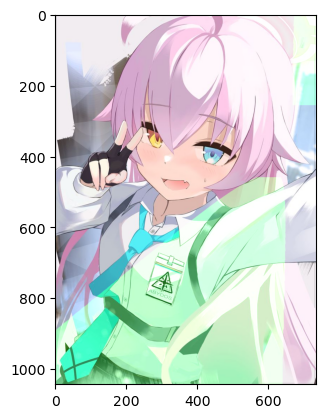

In [4]:
project_lane_test(r'C:\Users\HKIT\vscode\numpy\v24_11_22\images2\hoshino.jpg')